In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.sparse as sparse
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import os, shutil
import sys
sys.path.insert(0, '..')
from protosim_utils import build_dataset

## Load data

In [2]:
data = np.load('../checkpoints_passnet/stats.npz', allow_pickle=True)

In [3]:
print(data['token_counts'].shape, data['class_counts'].shape, data['instance_counts'][()].shape)
token_counts = data['token_counts']
instance_counts = data['instance_counts'][()]
instance_class = data['instance_class']
instance_class = data['instance_class'][:,0]
instance_dset = data['instance_class'][:,1]
print("datasets:", np.unique(instance_dset))
data.close()
instance_counts = instance_counts.todok()

(197, 8192) (1020, 8192) (2720886, 8192)
datasets: [0 1]


In [4]:
data_path = '/home/nanne/workspace/data/ImageNet1K/train,/home/nanne/workspace/data/PASS_dataset'

dataset, nb_classes = build_dataset(data_path, transform=None)
print("classes", nb_classes)

classes 1020


## Look at correlations between prototypes based on instance-level information

In [5]:
def compute_sparse_correlation_matrix(A):
    scaler = StandardScaler(with_mean=False)
    scaled_A = scaler.fit_transform(A)  # Assuming A is a CSR or CSC matrix
    corr_matrix = (1/scaled_A.shape[0]) * (scaled_A.T @ scaled_A)
    return corr_matrix

In [6]:
ic = instance_counts.tocsr()

In [7]:
# Most frequent prototypes across instances
sumz = np.array(ic.sum(0)).flatten()
for x in np.argsort(sumz, axis=None)[::-1][:15]:
    print(x, sumz[x])

582 449931898
6471 74757294
6611 689836
6912 524443
2799 516185
1398 393049
558 366500
5309 352211
6737 335932
5465 223651
7049 215387
3090 210779
1971 193918
6896 193911
1442 192236


In [8]:
icor = compute_sparse_correlation_matrix(ic) # |prototype| x |prototype| matrix

In [9]:
icor.max() # it's an approximation :x

15.86591107354492

In [10]:
# which prototype is most correlated with prototype f
f = 6471
for x in np.argsort(icor[f,:].toarray(), axis=None)[::-1][:15]:
    print(x, icor[f, x])

582 1.6019409083851897
6471 1.4493669881047586
1971 0.23909106450293166
6611 0.22469312599966756
6737 0.2163736241185892
5465 0.19543880688308013
1442 0.19348806486776904
2788 0.17458281612217644
558 0.1707015312871315
5065 0.16360589394607308
4845 0.15181149191675752
1445 0.14327587403403785
5506 0.1389683614653282
361 0.13792909258728214
5939 0.1305252171304324


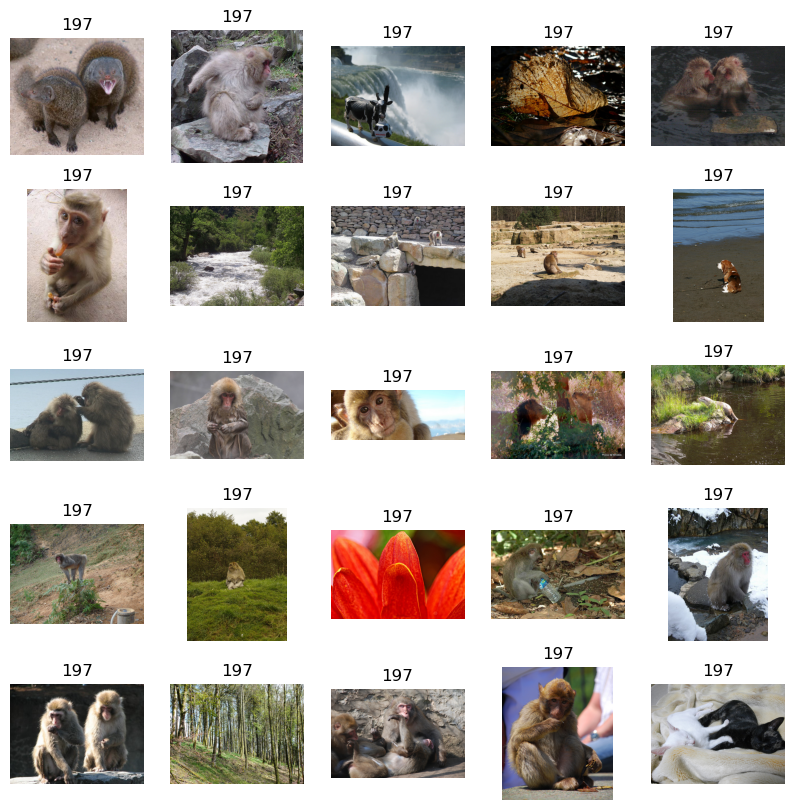

In [11]:
# The top images that contain prototype f
f = 582
figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for ix, ax in zip(np.argsort(ic[:, f].toarray(), axis=0).flatten()[::-1][:25], axes.flat):
    ax.imshow(dataset[ix][0])
    ax.title.set_text(ic[ix,f]) # prototype frequency as title
    ax.axis('off')
plt.show()

In [12]:
# Find pairs of prototypes with strongest correlations

tt = icor.toarray()
np.fill_diagonal(tt, 0)
tt = np.triu(tt) # zero lower triangle - to remove symmetric results

ind = np.unravel_index(np.argsort(tt, axis=None)[::-1], tt.shape)

indx = list(zip(ind[0], ind[1]))

for ix in indx[:50]:
    print(ix, icor[ix[0], ix[1]])

(582, 6471) 1.6019409083851897
(3002, 4282) 0.8115304072181247
(3590, 3833) 0.6618371576180943
(12, 8171) 0.6601129281395927
(4181, 4713) 0.6516734689499207
(1829, 5115) 0.6511407050510365
(4574, 5407) 0.6509420169929904
(3441, 6007) 0.649738788790351
(1098, 2307) 0.6328812250030569
(3882, 6921) 0.6264569278647613
(3800, 8155) 0.624224876579162
(1416, 2084) 0.6207296370985866
(1740, 2041) 0.6167099501153932
(7248, 7883) 0.6033192978017689
(1072, 3340) 0.5982073344985702
(3831, 3842) 0.5962764742579503
(296, 1650) 0.5951732602897796
(1786, 3422) 0.5899535993444972
(4915, 7265) 0.5871857748576754
(5263, 7380) 0.5852586594891661
(3891, 5498) 0.5804841807671881
(4178, 7411) 0.5735933045430067
(1241, 2829) 0.5725594757381636
(1020, 5222) 0.5715018185390578
(2010, 6897) 0.5625623138151417
(1744, 6750) 0.5512272828524865
(2776, 4143) 0.5419675186463601
(2240, 6966) 0.5255387251727064
(4373, 7479) 0.5207387069486942
(1702, 3829) 0.515338866981317
(4460, 7065) 0.5097039456664284
(6011, 7028) 0.

In [13]:
# get raw counts for prototype f_1 and f_2
f = (3002, 4282)
np.sum(ic[:,f[0]]), np.sum(ic[:,f[1]])

(10960, 1356)

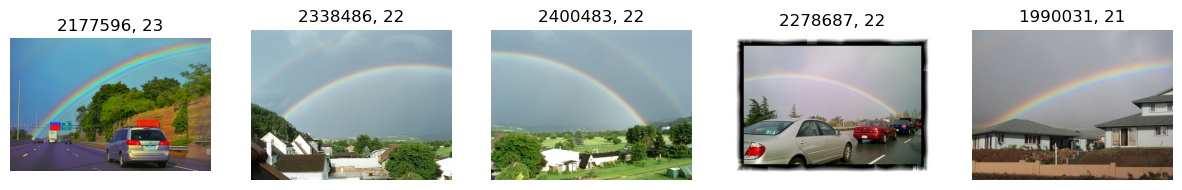

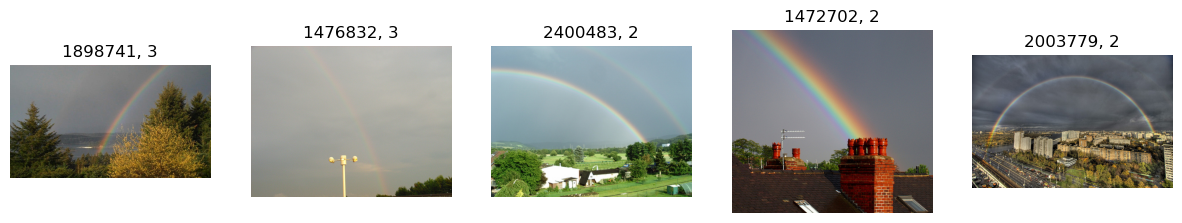

In [14]:
# get top images for f_1 and f_2
# these images should be similar along some dimension (may not always be directly obvious)

figure, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10))
for ix, ax in zip(np.argsort(ic[:, f[0]].toarray(), axis=0).flatten()[::-1][:5], axes.flat):
    ax.imshow(dataset[ix][0])
    ax.title.set_text(f"{ix}, {ic[ix, f[0]]}") # image id and count
    ax.axis('off')
plt.show()

figure, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10))
for ix, ax in zip(np.argsort(ic[:, f[1]].toarray(), axis=0).flatten()[::-1][:5], axes.flat):
    ax.imshow(dataset[ix][0])
    ax.title.set_text(f"{ix}, {ic[ix, f[1]]}") # image id and count
    ax.axis('off')
plt.show()

In [15]:
# which prototype has the highest sum of correlations to others?
sumz = icor.toarray().sum(axis=1).flatten()
for ix in np.argsort(sumz)[::-1][:15]:
    print(ix, sumz[ix])

582 101.1764280752714
6471 22.42358740757237
6611 11.827173583571819
6912 9.234641410336149
1971 8.289089685611055
3090 8.117911647994436
5540 7.804251021144542
6279 7.770638166853531
6737 7.329220030053713
1398 6.619164690208147
3419 6.561121164477688
7548 6.478596717438257
6011 6.2417481028000745
2642 6.1924154276144545
2799 5.961147136122942


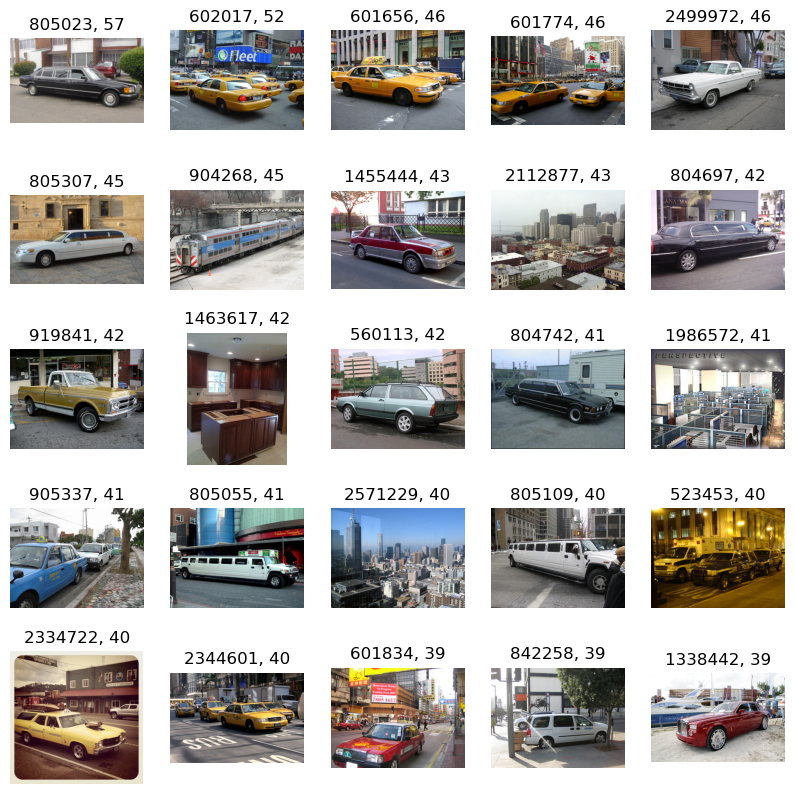

In [16]:
# show top images for f
f = 6611
figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for ix, ax in zip(np.argsort(ic[:, f].toarray(), axis=0).flatten()[::-1][:25], axes.flat):
    ax.imshow(dataset[ix][0])
    ax.title.set_text(f"{ix}, {ic[ix, f]}") # image id and count
    ax.axis('off')
plt.show()

## Look for difference across dataset

In [17]:
instance_counts.shape, instance_dset.shape
datasets = np.unique(instance_dset)
datasets

array([0, 1], dtype=int32)

In [18]:
# occurence count of f split by dataset
f = 6611

for d in datasets:
    print(d, instance_counts[(instance_dset == d), f].sum())

0 310659
1 379177


In [19]:
# how many "strong" (above threshold) occurences are there for prototype f
threshold = 2

for d in datasets:
    print(d, (instance_counts[(instance_dset == 0), f] > threshold).nonzero()[0].flatten().shape[0])

0 34552
1 34552


# Find different prototypes between datasets

In [20]:
ixcounts = instance_counts.tocsc()

In [21]:
startends = []
prev = 0
for d in datasets:
    startends.append((prev, np.where(instance_dset == d)[-1][-1])) # determine where each dataset starts and ends
    prev = startends[-1][1]
print(startends)

[(0, 1281166), (1281166, 2720885)]


In [22]:
# calculate stats per dataset
# mean is useful as it accounts for prototypes that occur A LOT in a few images
dataset_counts = np.array(np.concatenate([ixcounts[s:e, :].mean(axis=0) for s,e in startends], axis=0))
# sumz is actual raw count
dataset_sumz = np.array(np.concatenate([ixcounts[s:e, :].sum(axis=0) for s,e in startends], axis=0))
dataset_counts.shape

(2, 8192)

In [23]:
# for each dataset print which prototypes are most predominantly found in that dataset
for d in datasets:
    other_dset_counts = dataset_counts[np.arange(len(datasets)) != d].sum(axis=0)
    # find most like dataset, normalise for mean across datasets
    most_like = (dataset_counts[d,:] - other_dset_counts) / (dataset_counts.mean(axis=0)+0.000001)
    print("Prototypes predominantly found in dataset", d)
    print("prototype", "rate", "count within", "count in others", sep=" & ")
    for ix in np.argsort(most_like)[::-1][:15]:
        print(ix, most_like[ix], dataset_sumz[d, ix], dataset_sumz[np.arange(len(datasets)) != d][:, ix], sep=" & ")
    print()

Prototypes predominantly found in dataset 0
prototype & rate & count within & count in others
1771 & 1.9913998293079544 & 33220 & [79]
4337 & 1.985267417822136 & 586 & [1]
6501 & 1.9847407051534525 & 25430 & [108]
6972 & 1.9786524845193294 & 1896 & [10]
324 & 1.9733006390263343 & 47466 & [357]
4300 & 1.9690527385403753 & 3701 & [31]
5884 & 1.9669439147155987 & 900 & [7]
334 & 1.9666199289435347 & 10514 & [98]
5918 & 1.9615620659784803 & 28562 & [310]
7013 & 1.9548780995776707 & 345 & [3]
6331 & 1.953984910829243 & 18231 & [237]
7787 & 1.9510006371278659 & 67407 & [938]
3800 & 1.940732773491212 & 3279 & [54]
1072 & 1.932454424357121 & 695 & [12]
1717 & 1.9290871076463418 & 16587 & [335]

Prototypes predominantly found in dataset 1
prototype & rate & count within & count in others
744 & 1.966704030734051 & 6864 & [50]
6752 & 1.96563037973357 & 424 & [2]
6698 & 1.9573327206223476 & 549 & [4]
3882 & 1.9537750956768123 & 5216 & [53]
5277 & 1.9515570051735946 & 116 & [0]
4674 & 1.94244768468

Dataset: 0


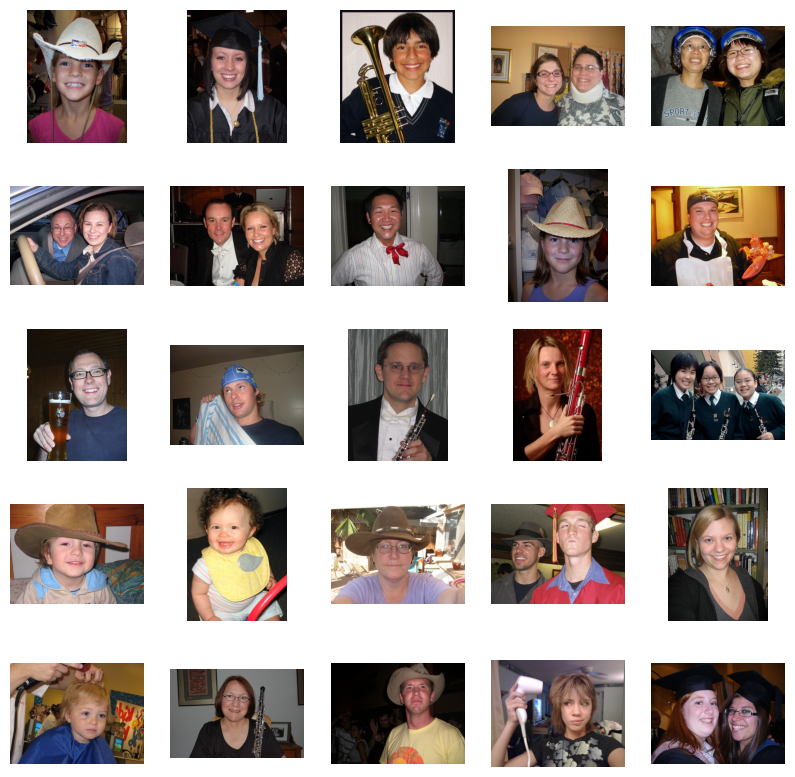

Dataset: 1


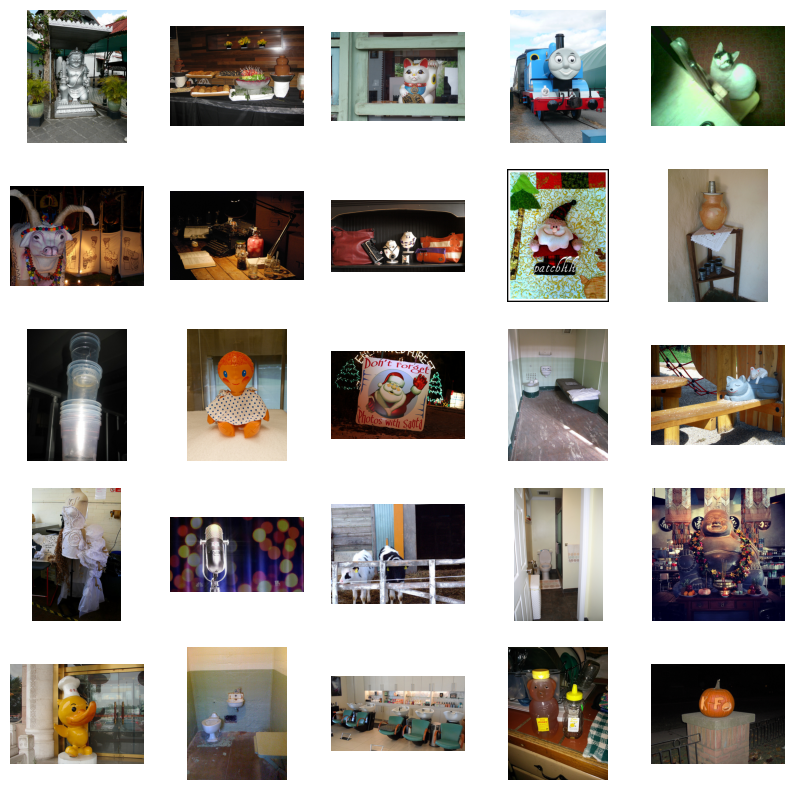

In [24]:
f = 1771
# visualise top images for f in per dataset

for d in datasets:
    figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10)) 
    print("Dataset:", d)
    for ix, ax in zip(np.argsort(ic[startends[d][0]:startends[d][1], f].toarray(), axis=0).flatten()[-25:][::-1], axes.flat):
        if ic[startends[d][0]+ix, f] > 0:
            ax.imshow(dataset[startends[d][0]+ix][0])
            #print(dataset.datasets[d].samples[ix-d])
        ax.axis('off')
    plt.show()

# Find similar

In [25]:
# find which prototypes are most shared across datasets
threshold = 500 # discard 'similar' ones that occur in neither dataset
diff = np.abs(np.diff(dataset_counts, n=len(datasets)-1, axis=0)[0]) / (dataset_counts.mean(axis=0)+0.000001)
print("Prototypes shared across datasets")
print("prototype", "rate", "counts", sep=" & ")
for ix in [x for x in np.argsort(diff) if dataset_sumz[:, x].sum() > threshold][:15]:
    print(ix, diff[ix], dataset_sumz[:, ix], sep=" & ")

Prototypes shared across datasets
prototype & rate & counts
5739 & 0.002196287454814754 & [8830 9901]
469 & 0.0037131717938670393 & [1743 1966]
5266 & 0.005041208654778719 & [5656 6324]
582 & 0.007288205911929249 & [212673698 237258004]
8026 & 0.015424030484289185 & [2726 3111]
172 & 0.016159116503007286 & [596 659]
4157 & 0.01747890558952305 & [564 645]
1416 & 0.023694791689460343 & [6350 7307]
2084 & 0.02383317680570243 & [504 553]
6471 & 0.025661755612780716 & [34722881 40034412]
4181 & 0.028685170739814064 & [690 798]
2726 & 0.031235195598546754 & [5338 6189]
2776 & 0.038950961049193975 & [3337 3899]
2583 & 0.040606386893708775 & [ 975 1052]
3630 & 0.04087922130342714 & [4207 4925]


In [26]:
f = 5739

# get raw counts for prototype f
for d in datasets:
    print(d, instance_counts[(instance_dset == d), f].sum())

0 8830
1 9901


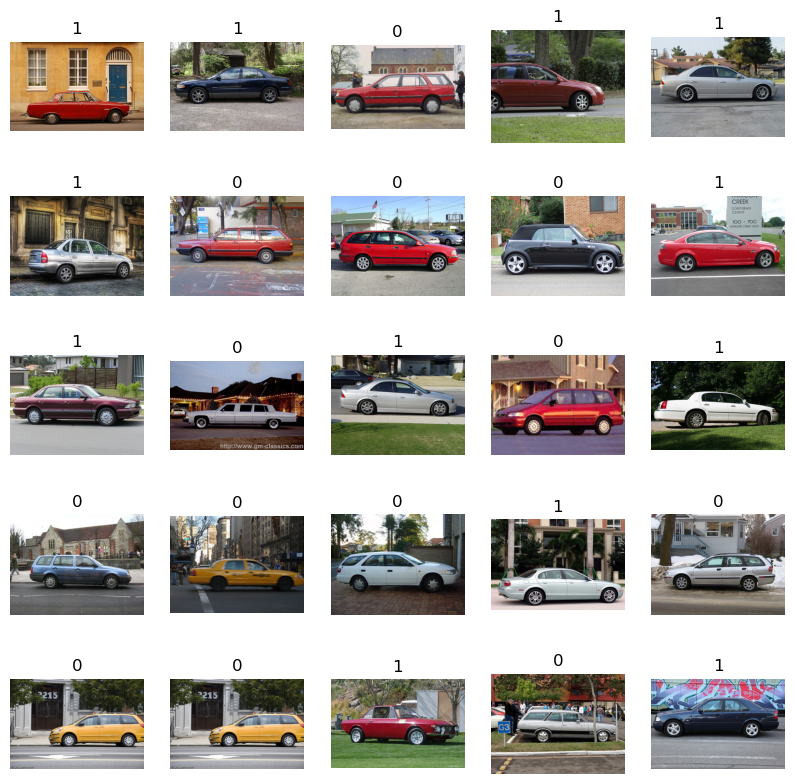

In [27]:
# visualise top images for f, across all datasets
f = 5739
figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for ix, ax in zip(np.argsort(ic[:, f].toarray(), axis=0).flatten()[::-1][:25], axes.flat):
    if ic[ix, f] > 0:
        ax.imshow(dataset[ix][0])
        ax.set_title(instance_dset[ix]) # in which dataset?
        #print(dataset.datasets[instance_dset[ix]].samples[ix - startends[instance_dset[ix]][0]])
    ax.axis('off')
plt.show()

Dataset: 0


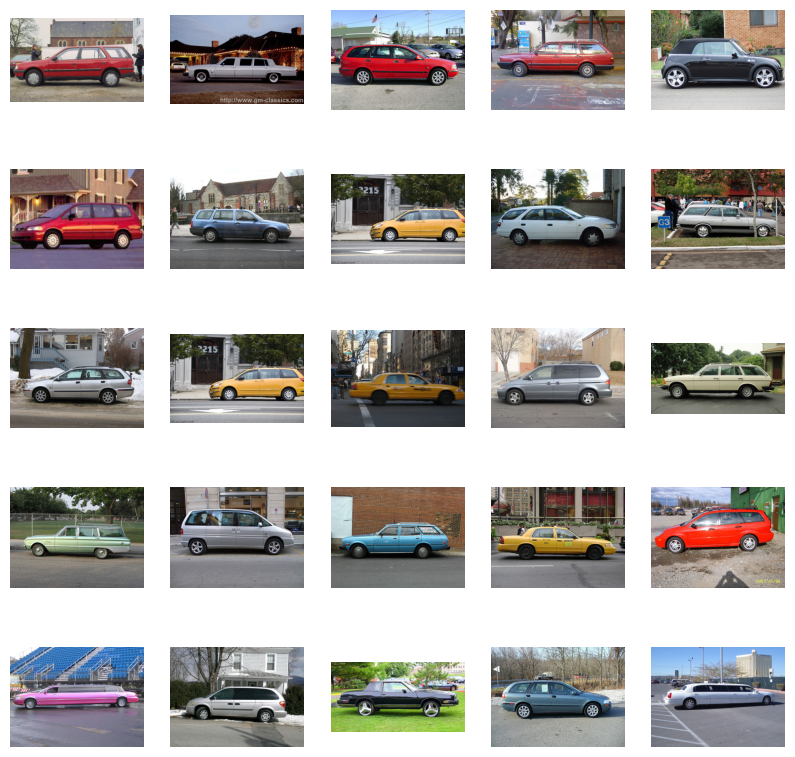

Dataset: 1


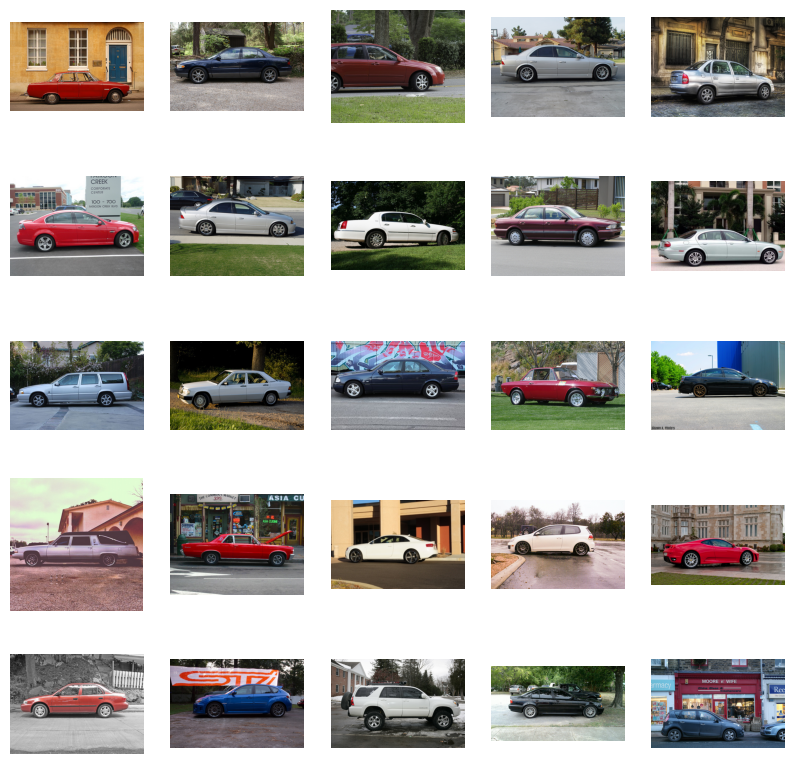

In [28]:
f = 5739
# visualise top images for f in per dataset

for d in datasets:
    figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10)) 
    print("Dataset:", d)
    for ix, ax in zip(np.argsort(ic[startends[d][0]:startends[d][1], f].toarray(), axis=0).flatten()[-25:][::-1], axes.flat):
        if ic[startends[d][0]+ix, f] > 0:
            ax.imshow(dataset[startends[d][0]+ix][0])
            #print(dataset.datasets[d].samples[ix-d])
        ax.axis('off')
    plt.show()

## Visualise stuff

In [ ]:
plt.figure(figsize=(20,5))
for d in datasets:
    plt.bar(range(8192), dataset_counts[d,:], bottom=dataset_counts[:d,:].sum(axis=0))
plt.yscale('log')
plt.show()

In [ ]:
colours = ['#fd625e', '#01b8aa', '#816E94', '#74226C', '#F3FFB6', '#C5E063', '#214F4B', '#513C2C', '#FFBA08', '#044389']

fig, axes = plt.subplots(figsize=(10,5), ncols=len(datasets), sharey=True)
if len(datasets) == 1: axes = [axes]
fig.tight_layout()

for d,c in zip(datasets, colours):
    axes[d].barh(range(8192), dataset_counts[d,:], align='center', color=c, zorder=10)
    axes[d].set_title(f"Dataset_{d}", fontsize=18, pad=15, color=c)
    axes[d].set_xscale('log')

axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

#axes[0].set(yticks=data.index, yticklabels=data.index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='white') # tick color

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
plt.show()